<a href="https://colab.research.google.com/github/vihar27/dspl/blob/master/Copy_of_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM for the prediction of energy consumption data over 48 hours
### 1 - LSTM with Energy consumption data and weather data
### 2 - LSTM with Energy consumption data and 2 variables 'Lastgang_Moving_Average' and 'Lastgang_First_Difference'

In [ ]:
#Install all required packages with 'conda install NAME' or with pip install NAME'
# pandas
# numpy
# matplotlib
# scikit-learn
# torch
# gputil
# psutil
# torchsummary

In [ ]:
#Import all required libraries
import sys  # Provides access to some variables used or maintained by the interpreter
import pandas as pd # Library for data manipulation and analysis, ideal for working with structured data like tables
import numpy as np # For scientific computing, supports large, multi-dimensional arrays and matrices
import matplotlib.pyplot as plt # For creating static, interactive, and animated visualizations
import matplotlib.dates as mdates # Provides classes for manipulating dates in plots
from pathlib import Path  # Used for filesystem path manipulation in an object-oriented way
import torch # Scientific computing library for ML and neural networks
import torch.nn as nn # Module in PyTorch providing various layers and parameters for neural networks, facilitates building and training
from sklearn.metrics import mean_squared_error, mean_absolute_error # For calculating key regression metrics
from sklearn.preprocessing import MinMaxScaler # For scaling and normalizing features, often useful in data preprocessing
import os # Provides a way of using operating system dependent functionality
import GPUtil # For monitoring GPU utilization
from datetime import datetime # For handling dates and times
import psutil # For accessing system details and process utilities
from torchsummary import summary  # Import summary from torchsummary to display a summary of model layers and parameters

In [ ]:
#To display the current environment
print(sys.executable)

/home/sarah/anaconda3/envs/BT2024PyTorch/bin/python


In [ ]:
# Step 1 - Reading Data

## dfClimaAll: Data from 2021-2023
## dfEnergyAll: All data from the transformer station from 2021-2023

# Load data for 2021
dfClima21 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2021TimeWeather.xlsx')

# Load data for 2022
dfClima22 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2022TimeWeather.xlsx')

# Load data for 2023
dfClima23 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2023TimeWeather.xlsx')

# Merge the DataFrames
dfClimaAll = pd.concat([dfClima21, dfClima22, dfClima23])

# Check the resulting DataFrame
print("First and last rows from dfClimaAll:")
print(dfClimaAll.head())
print(dfClimaAll.tail())

# Check for missing values in each column
## .isnull(): Returns DF where values with NaN are replaced by True & values without NaN are replaced by False
## sum(): Sums up the number of True values
print("Number of missing values per column:")
print(dfClimaAll.isnull().sum())

# Convert 'Timestamp' into a Datetime object and set it as index, if not already set
if 'TimestampWeather' in dfClimaAll.columns:
    ## pd.to_datetime: Converts values into Datetime objects —> Pandas can then treat these as timestamps
    dfClimaAll['TimestampWeather'] = pd.to_datetime(dfClimaAll['TimestampWeather'])
    ## set_index: Sets index for the Timestamp column to facilitate access to data based on time points
    dfClimaAll = dfClimaAll.set_index('TimestampWeather')

# Number of rows in dfClimaAll
print("Number of rows in dfClimaAll:", dfClimaAll.shape[0])


First and last rows from dfClimaAll:
   dy  Globalstrahlung_15Min  Sonnenhöhe  ExtraterrestrischeStrahlung  \
0   1                      0       -65.0                            0   
1   1                      0       -65.0                            0   
2   1                      0       -65.4                            0   
3   1                      0       -65.5                            0   
4   1                      0       -65.2                            0   

   StundenwertStrahlung  Diffusstrahlung  StrahlungGeneigteFläche  \
0                     0                0                        0   
1                     0                0                        0   
2                     0                0                        0   
3                     0                0                        0   
4                     0                0                        0   

   DiffusstrahlungGeneigteFläche  Direktnormalstrahlung  Lufttemperatur  \
0                              0  

In [ ]:
# Step 1 - Reading Data

## dfClimaAll: Data from 2021-2023
## dfEnergyAll: All data from the transformer station from 2021-2023

# Path to the directory containing the Excel files
directory_path = Path('/home/sarah/Documents/BT2024/All')

# Create a list of all Excel files in the directory
file_paths = list(directory_path.glob('*.xlsx'))

# List to store the individual DataFrames
dfs = []

# Loop over all file paths
for file_path in file_paths:
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Convert the 'Timestamp' column to a datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Convert the 'Lastgang' column to a numeric type, treat errors as NaN
    df['Lastgang'] = pd.to_numeric(df['Lastgang'], errors='coerce')

    # Sort the DataFrame by 'Timestamp'
    df = df.sort_values(by='Timestamp')

    # Perform linear interpolation for 'Lastgang' on the individual DataFrame
    df['Lastgang'] = df['Lastgang'].interpolate(method='linear')

    # Add the DataFrame to the list
    dfs.append(df)

# Merge all DataFrames in the list
dfEnergyAll = pd.concat(dfs).set_index('Timestamp')

# Sum the 'Lastgang' values for identical timestamps
dfEnergyAll = dfEnergyAll.groupby('Timestamp').sum()

# Check the resulting DataFrame
print("First and last rows from dfEnergyAll:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

# Display the number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

First and last rows from dfEnergyAll:
                     Lastgang
Timestamp                    
2021-01-01 00:00:00    472.88
2021-01-01 00:15:00    498.83
2021-01-01 00:30:00    480.48
2021-01-01 00:45:00    446.74
2021-01-01 01:00:00    459.55
                     Lastgang
Timestamp                    
2023-12-31 22:45:00    833.17
2023-12-31 23:00:00    767.89
2023-12-31 23:15:00    770.04
2023-12-31 23:30:00    730.45
2023-12-31 23:45:00    744.21
Number of rows in dfEnergyAll: 105108


In [ ]:
# Step 2 - Preparing the Data

# Create a complete timestamp index for the years 2021 - 2023 in 15-minute intervals
all_timestamps = pd.date_range(start='2021-01-01 00:00:00', end='2023-12-31 23:45:00', freq='15T')

# Convert this into a DataFrame
df_all_timestamps = pd.DataFrame(all_timestamps, columns=['Timestamp'])
df_all_timestamps = df_all_timestamps.set_index('Timestamp')

# Compare the complete timestamp index with dfEnergyAll
missing_timestamps = df_all_timestamps.index.difference(dfEnergyAll.index)

print("Missing timestamps in dfEnergyAll:")
print(missing_timestamps)


# Missing timestamps
missing_timestamps = pd.DatetimeIndex(['2021-03-28 02:00:00', '2021-03-28 02:15:00',
                                       '2021-03-28 02:30:00', '2021-03-28 02:45:00',
                                       '2022-03-27 02:00:00', '2022-03-27 02:15:00',
                                       '2022-03-27 02:30:00', '2022-03-27 02:45:00',
                                       '2023-03-26 02:00:00', '2023-03-26 02:15:00',
                                       '2023-03-26 02:30:00', '2023-03-26 02:45:00'])

# Create a DataFrame with the missing timestamps
df_missing = pd.DataFrame(index=missing_timestamps)

# Merge this DataFrame with the original DataFrame
dfEnergyAll = dfEnergyAll.combine_first(df_missing)

# Fill the missing values. Use 'ffill' for forward fill.
dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')

print("Check after adding the missing timestamps:")
print(dfEnergyAll.loc[missing_timestamps])

# Number of rows in dfClima21
# Ensure dfClima21 is already defined before executing this line.
print("Number of rows in dfClima21:", dfClimaAll.shape[0])

# Number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

Missing timestamps in dfEnergyAll:
DatetimeIndex(['2021-03-28 02:00:00', '2021-03-28 02:15:00',
               '2021-03-28 02:30:00', '2021-03-28 02:45:00',
               '2022-03-27 02:00:00', '2022-03-27 02:15:00',
               '2022-03-27 02:30:00', '2022-03-27 02:45:00',
               '2023-03-26 02:00:00', '2023-03-26 02:15:00',
               '2023-03-26 02:30:00', '2023-03-26 02:45:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)
Check after adding the missing timestamps:
                     Lastgang
2021-03-28 02:00:00    372.28
2021-03-28 02:15:00    372.28
2021-03-28 02:30:00    372.28
2021-03-28 02:45:00    372.28
2022-03-27 02:00:00    554.20
2022-03-27 02:15:00    554.20
2022-03-27 02:30:00    554.20
2022-03-27 02:45:00    554.20
2023-03-26 02:00:00    520.34
2023-03-26 02:15:00    520.34
2023-03-26 02:30:00    520.34
2023-03-26 02:45:00    520.34
Number of rows in dfClima21: 105120
Number of rows in dfEnergyAll: 105120


/tmp/ipykernel_1514655/1871761932.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')


## 1 - LSTM with Energy consumption data and weather data

In [ ]:
# Step 2 - Preparing the Data

# To check if the indexes in both DataFrames are set equally
dfClimaAll.index.equals(dfEnergyAll.index)

# Adding the columns from dfClima21 to dfEnergyAll
dfEnergyAll = dfEnergyAll.join(dfClimaAll[['StundenwertStrahlung', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'TheorPVProd', 'Direktnormalstrahlung', 'Schönwetterstrahlung', 'Lufttemperatur']])

# Checking for missing values in each column
print("Number of missing values per column:")
print(dfEnergyAll.isnull().sum())

# Printing the first and last rows from the dataframe
print("First and last rows from dfEnergyAll-Edited:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

Number of missing values per column:
Lastgang                   0
StundenwertStrahlung       0
Globalstrahlung_15Min      0
StrahlungGeneigteFläche    0
TheorPVProd                0
Direktnormalstrahlung      0
Schönwetterstrahlung       0
Lufttemperatur             0
dtype: int64
First and last rows from dfEnergyAll-Edited:
                     Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
2021-01-01 00:00:00    472.88                     0                      0   
2021-01-01 00:15:00    498.83                     0                      0   
2021-01-01 00:30:00    480.48                     0                      0   
2021-01-01 00:45:00    446.74                     0                      0   
2021-01-01 01:00:00    459.55                     0                      0   

                     StrahlungGeneigteFläche  TheorPVProd  \
2021-01-01 00:00:00                        0            0   
2021-01-01 00:15:00                        0            0   
2021-01-01 00:30:00  

In [ ]:
# Step 2 - Preparing the Data

# Calculating the moving average for 'Lastgang'
window_size = 96  # This corresponds to 24 hours at 15-minute intervals
dfEnergyAll['Lastgang_Moving_Average'] = dfEnergyAll['Lastgang'].rolling(window=window_size).mean()

# Calculating the first differences for 'Lastgang'
dfEnergyAll['Lastgang_First_Difference'] = dfEnergyAll['Lastgang'].diff()

# Since the first `window_size - 1` values of the moving average will be NaN and the first value of the first difference will be NaN, fill these values.
dfEnergyAll = dfEnergyAll.fillna(method='bfill')

# To check the first few rows to ensure the new features look as expected.
print(dfEnergyAll.head())

                     Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
2021-01-01 00:00:00    472.88                     0                      0   
2021-01-01 00:15:00    498.83                     0                      0   
2021-01-01 00:30:00    480.48                     0                      0   
2021-01-01 00:45:00    446.74                     0                      0   
2021-01-01 01:00:00    459.55                     0                      0   

                     StrahlungGeneigteFläche  TheorPVProd  \
2021-01-01 00:00:00                        0            0   
2021-01-01 00:15:00                        0            0   
2021-01-01 00:30:00                        0            0   
2021-01-01 00:45:00                        0            0   
2021-01-01 01:00:00                        0            0   

                     Direktnormalstrahlung  Schönwetterstrahlung  \
2021-01-01 00:00:00                      0                     0   
2021-01-01 00:15:00         

/tmp/ipykernel_1514655/1800522370.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.fillna(method='bfill')


In [ ]:
# Step 3 - Data Scaling

# Initialize the scalers
lastgang_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the corresponding columns
dfEnergyAll['Lastgang'] = lastgang_scaler.fit_transform(dfEnergyAll['Lastgang'].values.reshape(-1, 1))
dfEnergyAll[['StundenwertStrahlung', 'Lufttemperatur', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']] = features_scaler.fit_transform(dfEnergyAll[['StundenwertStrahlung', 'Lufttemperatur', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']])


In [ ]:
# Step 3 - Check the scaled values

print(dfEnergyAll.describe())

print("Skalierparameter für Lastgang:", lastgang_scaler.scale_, lastgang_scaler.min_)

            Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
count  105120.000000         105120.000000          105120.000000   
mean        0.425947              0.561652               0.125328   
std         0.149590              0.111328               0.197261   
min         0.000000              0.000000               0.000000   
25%         0.312299              0.490186               0.000000   
50%         0.397657              0.492149               0.000861   
75%         0.527101              0.593719               0.182444   
max         1.000000              1.000000               1.000000   

       StrahlungGeneigteFläche    TheorPVProd  Direktnormalstrahlung  \
count            105120.000000  105120.000000          105120.000000   
mean                  0.125328     116.568056             144.916924   
std                   0.197261     177.407501             266.941484   
min                   0.000000       0.000000               0.000000   
25%               

In [ ]:
# Step 3 - Show GPU Utilization and Memory Usage before Model Training

def print_gpu_utilization():
    # Retrieve and print GPU utilization and memory stats
    GPUs = GPUtil.getGPUs()
    for GPU in GPUs:
        print(f"GPU: {GPU.name}, GPU RAM Free: {GPU.memoryFree}MB, Used: {GPU.memoryUsed}MB, Utilization: {GPU.load*100}%")

print("GPU before model training:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print_gpu_utilization()

# Function to print CPU utilization
def print_cpu_utilization():
    # Retrieve and print the percentage of CPU utilization
    print(f"CPU Utilization: {psutil.cpu_percent(interval=1)}%")

print("CPU before model training:")
print_cpu_utilization()

def print_memory_usage():
    # Retrieve and print memory statistics
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage: {memory.percent}%")

print("RAM before model training:")
print_memory_usage()


GPU before model training: 2024-05-03 17:00:39
GPU: NVIDIA A100 80GB PCIe, GPU RAM Free: 17694.0MB, Used: 63345.0MB, Utilization: 92.0%
GPU: NVIDIA A100 80GB PCIe, GPU RAM Free: 236.0MB, Used: 80803.0MB, Utilization: 28.000000000000004%
CPU before model training:
CPU Utilization: 89.2%
RAM before model training:
Total memory: 146.88 GB
Available memory: 115.63 GB
Used memory: 29.34 GB
Memory usage: 21.3%


In [ ]:
# Step 4 - Creating the sequences and the LSTM model

def create_sequences(data, seq_length):
    # Create input/output sequences from the dataset for model training
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].to_numpy() # Extract input sequence
        y = data.iloc[i + seq_length, 0] # Extract the corresponding output
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 192
X, y = create_sequences(dfEnergyAll, seq_length)  # Generate sequences using the specified sequence length

# Split the dataset into training and testing sets using the last 192 sequences for testing
X_train, X_test = X[:-192], X[-192:]
y_train, y_test = y[:-192], y[-192:]

In [ ]:
# Step 4 - Creating the sequences and the LSTM model

# Print the shapes of the training and testing datasets
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")

X_train Shape: (104736, 192, 10)
X_test Shape: (192, 192, 10)


In [ ]:
# Step 4 - Creating the sequences and the LSTM model

# Check Hardware Availability for the PyTorch code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Step 4 - Creating the sequences and the LSTM model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        # Initialize the LSTM layer with the specified input size and hidden layer size
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        # Initialize a linear layer to map the output of the LSTM to the desired output size
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq, hidden_state):
        # Define the forward pass through the LSTM layer followed by a linear layer
        lstm_out, hidden_state = self.lstm(input_seq, hidden_state) # LSTM output and updated hidden state
        predictions = self.linear(lstm_out[:, -1, :]) # Linear layer uses the last time step output
        return predictions, hidden_state

# Instantiate the LSTM model with specific dimensions for input size, hidden layer size, and output size
model = LSTMModel(10, 100, 1).to(device) # Model is set to run on the specified device (here GPU)

In [ ]:
# Step 4 - Creating the sequences and the LSTM model

#Convert training data into PyTorch tensors
# Convert training data to tensor and transfer it to the configured device (GPU or CPU)
X_train_tensors = torch.Tensor(X_train).to(device)
# Convert training labels to tensor, reshape to match the output format, and transfer to the device
y_train_tensors = torch.Tensor(y_train).view(-1, 1).to(device)

# Convert testing data to tensor and transfer it to the configured device
X_test_tensors = torch.Tensor(X_test).to(device)
# Convert testing labels to tensor, reshape to match the output format, and transfer to the device
y_test_tensors = torch.Tensor(y_test).view(-1, 1).to(device)

# Step 4 - Creating the sequences and the LSTM model

# Input dimension for torchsummary
# Call the summary function with the appropriate input size
seq_length = 192  # length of sequence
input_size = 10   # number of features
model_summary(model, (seq_length, input_size))

In [ ]:
# Step 5 - Model Training

# Define the number of epochs and batch size
loss_function = nn.MSELoss() # Define the loss function to measure the model performance
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Define the optimizer with a learning rate of 0.001
epochs = 70 # Total number of epochs to train the model
batch_size = 12 # Number of samples in each batch

# For storing the loss values
train_losses = []  # List to store loss values for each epoch during training
test_losses = []  # List to store loss values for each epoch during validation

# Initialize variables for Early Stopping
best_test_loss = float('inf') # Set the best test loss to infinity
best_model_path = 'best_model.pth' # Path to save the best model
early_stopping_patience = 5  # Number of epochs to wait without improvement before stopping the training
epochs_without_improvement = 0  # Counter to track the number of epochs without improvement

for epoch in range(epochs): # Loop over the number of epochs
    model.train() # Set the model to training mode
    train_loss = 0.0 # Initialize the train loss for the epoch
    for i in range(0, len(X_train_tensors), batch_size): # Iterate over the training data in batches
        X_batch = X_train_tensors[i:i + batch_size] # Get the current batch of input data
        y_batch = y_train_tensors[i:i + batch_size] # Get the current batch of target data

        # Dynamic batch size adjustment for the last batch of the epoch
        actual_batch_size = X_batch.size(0)

        # Initialize the hidden and cell states based on the actual batch size
        hidden = (torch.zeros(1, actual_batch_size, model.hidden_layer_size).to(device),
                  torch.zeros(1, actual_batch_size, model.hidden_layer_size).to(device))

        optimizer.zero_grad()

        # Perform a forward pass through the model and store the new hidden state
        y_pred, hidden = model(X_batch, hidden)

        # Detach hidden state to prevent history from being saved
        hidden = tuple([h.detach() for h in hidden])

        loss = loss_function(y_pred, y_batch) # Calculate the loss
        loss.backward() #Perform backpropagation
        optimizer.step() # Update the weights

        train_loss += loss.item() * actual_batch_size # Accumulate the loss for the batch

    # Calculate the average training loss for the epoch
    train_loss /= len(X_train_tensors)
    train_losses.append(train_loss)

    # Validation
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Do not calculate gradients
        for i in range(0, len(X_test_tensors), batch_size):
            X_batch = X_test_tensors[i:i + batch_size]
            y_batch = y_test_tensors[i:i + batch_size]

            # Repeat the dynamic batch size adjustment for validation
            actual_batch_size = X_batch.size(0)
            hidden = (torch.zeros(1, actual_batch_size, model.hidden_layer_size).to(device),
                      torch.zeros(1, actual_batch_size, model.hidden_layer_size).to(device))

            y_pred = model(X_batch, hidden)[0]  # Get predictions only, state is ignored
            loss = loss_function(y_pred, y_batch)
            test_loss += loss.item() * actual_batch_size

    # Calculate the average test loss for the epoch
    test_loss /= len(X_test_tensors)
    test_losses.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), best_model_path) # Save the best model
        epochs_without_improvement = 0  # Reset since improvement was found
        print(f'Neues bestes Modell bei Epoche {epoch+1} mit Testverlust {test_loss} gespeichert.')
    else:
        epochs_without_improvement += 1  # Increment since no improvement

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

    # Check if the early stopping criterion is met
    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early Stopping nach {epoch+1} Epochen!')
        break  # End the loop and thus the training

/home/sarah/anaconda3/envs/BT2024PyTorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Neues bestes Modell bei Epoche 1 mit Testverlust 0.002240444806375308 gespeichert.
Epoch 1, Train Loss: 0.0035617551574962775, Test Loss: 0.002240444806375308
Epoch 2, Train Loss: 0.0028713790915957543, Test Loss: 0.003409684640246269
Epoch 3, Train Loss: 0.002853152419040494, Test Loss: 0.0028365009657136397
Epoch 4, Train Loss: 0.0026575870853470054, Test Loss: 0.002615272085677134
Epoch 5, Train Loss: 0.0024344039566272678, Test Loss: 0.002584929561635363
Epoch 6, Train Loss: 0.0022661723844511054, Test Loss: 0.0029679268427571515
Early Stopping nach 6 Epochen!


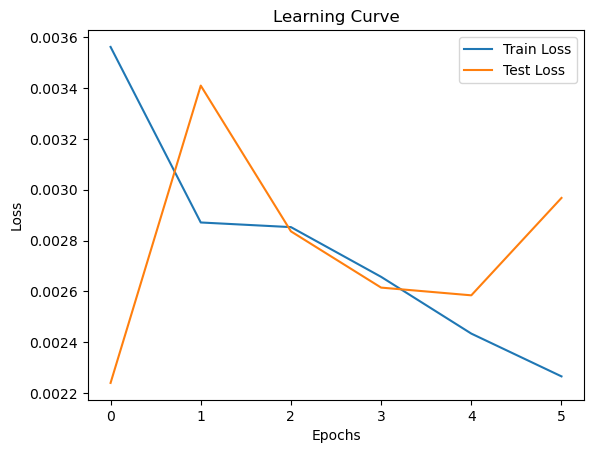

In [ ]:
# Step 5 - Model Training

#Printing the learning curve
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Mean Squared Error (MSE): 4835.649345629893
Mean Absolute Error (MAE): 48.19281085729443
Root Mean Square Error (RMSE): 69.53883336402684
Mean Absolute Percentage Error (MAPE): 5.7064004220498035%


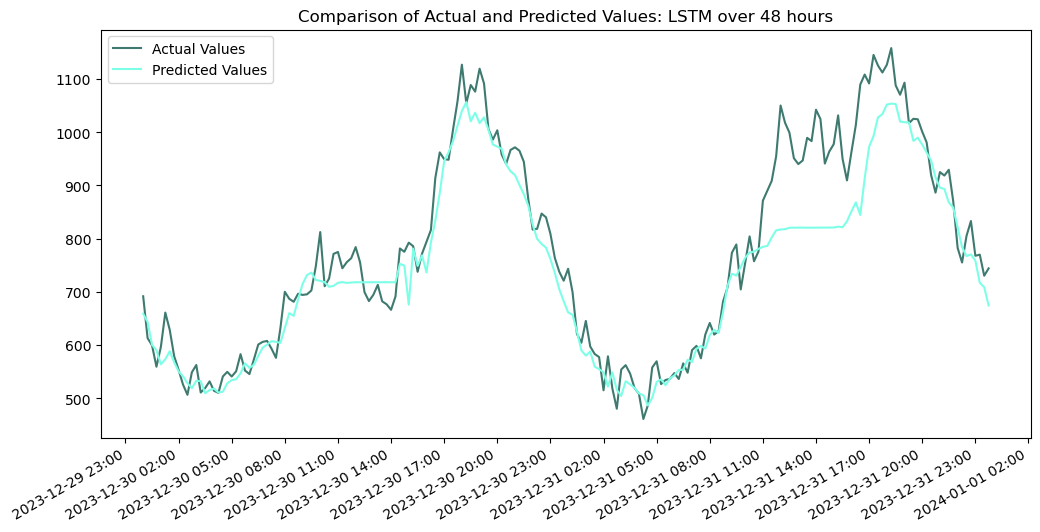

In [ ]:
# Step 6 - Rescaling, error metrics and visualization

# Load the best model weights
best_model_path = 'best_model.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

# Evaluate the model
model.eval()
test_predictions = []
with torch.no_grad():
    for i in range(len(X_test_tensors)):
        # Prepare each batch from the test data
        X_batch = X_test_tensors[i].unsqueeze(0)  # Add batch dimension
        # Predict using the model
        y_pred, _ = model(X_batch, (torch.zeros(1, 1, model.hidden_layer_size).to(device), torch.zeros(1, 1, model.hidden_layer_size).to(device)))
        test_predictions.append(y_pred.squeeze().item())  # Store the predicted values

# Denormalizing the predictions and actual values to their original scale
test_predictions_denorm = lastgang_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_denorm = lastgang_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
mse = mean_squared_error(y_test_denorm, test_predictions_denorm)  # Mean Squared Error
mae = mean_absolute_error(y_test_denorm, test_predictions_denorm)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Square Error
mape = np.mean(np.abs((y_test_denorm - test_predictions_denorm) / y_test_denorm)) * 100  # Mean Absolute Percentage Error

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Visualization of actual vs predicted values
plt.figure(figsize=(12, 6))
test_dates = pd.date_range(start=dfEnergyAll.index[-len(X_test):][0], periods=len(y_test), freq='15T')
plt.plot(test_dates, y_test_denorm, label='Actual Values', color='#3E7A6F')
plt.plot(test_dates, test_predictions_denorm, label='Predicted Values', color='#7DFFE7')
plt.legend()
plt.title('Comparison of Actual and Predicted Values: LSTM over 48 hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# Step 7 - Show GPU Utilization and Memory Usage after Model Training

print("GPU after model training:", datetime.now().strftime("%Y-%m-%d %H:%M:%S")) # Print GPU utilization after model training
print_gpu_utilization() # Call function to print GPU utilization

print("CPU after model training:") # Print CPU utilization after model training
print_cpu_utilization() # Call function to print CPU utilization

print("RAM after model training:") # Print RAM usage after model training
print_memory_usage() # Call function to print RAM usage

GPU after model training: 2024-05-03 16:44:12
GPU: NVIDIA A100 80GB PCIe, GPU RAM Free: 16696.0MB, Used: 64343.0MB, Utilization: 23.0%
GPU: NVIDIA A100 80GB PCIe, GPU RAM Free: 2326.0MB, Used: 78713.0MB, Utilization: 100.0%
CPU after model training:
CPU Utilization: 15.0%
RAM after model training:
Total memory: 146.88 GB
Available memory: 115.61 GB
Used memory: 29.27 GB
Memory usage: 21.3%


## 2 - LSTM with Energy consumption data and 2 variables 'Lastgang_Moving_Average' and 'Lastgang_First_Difference'

In [ ]:
# Step 3 - Data Scaling

# Initialize the scalers
lastgang_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for the target variable
features_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for the feature variables

# Apply the scaler to the appropriate columns
dfEnergyAll['Lastgang'] = lastgang_scaler.fit_transform(dfEnergyAll['Lastgang'].values.reshape(-1, 1))  # Scale the main target variable
dfEnergyAll[['Lastgang_Moving_Average', 'Lastgang_First_Difference']] = features_scaler.fit_transform(dfEnergyAll[['Lastgang_Moving_Average', 'Lastgang_First_Difference']])  # Scale selected features


In [ ]:
# Step 4 - Creating the sequences and the LSTM model

def create_sequences(data, seq_length):
    # Initialize lists to hold the input sequences (xs) and the corresponding target values (ys)
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        # Create a sequence of length seq_length from the data starting at index i
        x = data.iloc[i:(i + seq_length)].to_numpy()
        # Get the target value corresponding to the end of the sequence
        y = data.iloc[i + seq_length, 0]
        # Append the sequence to the list of inputs
        xs.append(x)
        # Append the target value to the list of outputs
        ys.append(y)
    # Convert lists to numpy arrays for further processing in machine learning models
    return np.array(xs), np.array(ys)

# Define the length of sequences
seq_length = 192
# Generate sequences and corresponding target values from the dataset
X, y = create_sequences(dfEnergyAll, seq_length)

# Use the last 192 sequences for testing to maintain a comparable distribution as in the TBATS model
X_train, X_test = X[:-192], X[-192:]  # Split the data into training and testing sets
y_train, y_test = y[:-192], y[-192:]  # Split the target values into training and testing sets


In [ ]:
# Step 4 - Creating the sequences and the LSTM model

# Print the shapes of the training and testing datasets
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")

In [ ]:
# Step 4 - Creating the sequences and the LSTM model

# Check Hardware Availability for the PyTorch code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Step 4 - Creating the sequences and the LSTM model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        # Initialize the LSTM layer with specified input size and hidden layer size
        self.hidden_layer_size = hidden_layer_size  # Store the hidden layer size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)  # LSTM module
        self.linear = nn.Linear(hidden_layer_size, output_size)  # Linear layer to map the LSTM outputs to the desired output size

    def forward(self, input_seq, hidden_state):
        # Define the forward pass of the LSTM model
        lstm_out, hidden_state = self.lstm(input_seq, hidden_state)  # Execute the LSTM layer
        predictions = self.linear(lstm_out[:, -1, :])  # Apply the linear layer to the last time step output of the LSTM
        return predictions, hidden_state  # Return the final predictions and the hidden state

# Initialize the LSTM model with specific dimensions
model = LSTMModel(3, 100, 1).to(device)  # 3 features as input, 'device' specifies where to run the model (here GPU)


In [ ]:
# Step 4 - Creating the sequences and the LSTM model

#Convert training data into PyTorch tensors
# Convert training data to tensor and transfer it to the configured device (GPU or CPU)
X_train_tensors = torch.Tensor(X_train).to(device)
# Convert training labels to tensor, reshape to match the output format, and transfer to the device
y_train_tensors = torch.Tensor(y_train).view(-1, 1).to(device)

# Convert testing data to tensor and transfer it to the configured device
X_test_tensors = torch.Tensor(X_test).to(device)
# Convert testing labels to tensor, reshape to match the output format, and transfer to the device
y_test_tensors = torch.Tensor(y_test).view(-1, 1).to(device)

In [ ]:
# Step 5 - Model Training

# Define the number of epochs and the batch size
loss_function = nn.MSELoss()  # Loss function to measure how well the model performs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer to update model weights
epochs = 70  # Total number of training epochs
batch_size = 12  # Number of samples per batch

# For storing loss values
train_losses = []  # List to store training loss per epoch
test_losses = []  # List to store validation loss per epoch

# Initialize variables for Early Stopping
best_test_loss = float('inf')  # Best loss for the validation set seen so far
best_model_path = 'best_model.pth'  # Path to save the best model
early_stopping_patience = 5  # Number of epochs to continue without improvement before stopping
epochs_without_improvement = 0  # Count of epochs since last improvement

for epoch in range(epochs):  # Iterate over each epoch
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Accumulator for the loss of the current epoch
    for i in range(0, len(X_train_tensors), batch_size):  # Iterate over batches
        X_batch = X_train_tensors[i:i + batch_size]  # Current batch of input data
        y_batch = y_train_tensors[i:i + batch_size]  # Current batch of target data

        # Dynamic adjustment of batch size for the last batch of the epoch
        actual_batch_size = X_batch.size(0)

        # Initialize hidden and cell states based on the actual batch size
        hidden = (torch.zeros(1, actual_batch_size, model.hidden_layer_size).to(device),
                  torch.zeros(1, actual_batch_size, model.hidden_layer_size).to(device))

        optimizer.zero_grad()  # Reset gradients

        # Store the new hidden state after forward pass
        y_pred, hidden = model(X_batch, hidden)

        # Detach hidden state to prevent saving history
        hidden = tuple([h.detach() for h in hidden])

        loss = loss_function(y_pred, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item() * actual_batch_size  # Aggregate loss for the epoch

    # Calculate average training loss for the epoch
    train_loss /= len(X_train_tensors)
    train_losses.append(train_loss)

    # Validation
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No gradient calculations
        for i in range(0, len(X_test_tensors), batch_size):
            X_batch = X_test_tensors[i:i + batch_size]
            y_batch = y_test_tensors[i:i + batch_size]

            # Repeat dynamic batch size adjustment for validation
            actual_batch_size = X_batch.size(0)
            hidden = (torch.zeros(1, actual_batch_size, model.hidden_layer_size).to(device),
                      torch.zeros(1, actual_batch_size, model.hidden_layer_size).to(device))

            y_pred = model(X_batch, hidden)[0]  # Only predictions needed, state ignored
            loss = loss_function(y_pred, y_batch)
            test_loss += loss.item() * actual_batch_size

    # Calculate average test loss for the epoch
    test_loss /= len(X_test_tensors)
    test_losses.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss  # Update the best test loss
        torch.save(model.state_dict(), best_model_path)  # Save the best model
        epochs_without_improvement = 0  # Reset since improvement was found
        print(f'New best model saved at epoch {epoch+1} with test loss {test_loss}.')
    else:
        epochs_without_improvement += 1  # Increment since no improvement

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

    # Check if early stopping criterion is met
    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early Stopping after {epoch+1} epochs!')
        break  # End the loop and thus the training


In [ ]:
# # Step 5 - Model Training

# Printint the Learning Curve
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:
# Step 6 - Rescaling, error metrics and visualization

# Load the best model weights
best_model_path = 'best_model.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

# Evaluate the model
model.eval()
test_predictions = []
with torch.no_grad():  # Disable gradient tracking for inference, which saves memory and computations
    for i in range(len(X_test_tensors)):
        X_batch = X_test_tensors[i].unsqueeze(0)  # Add a batch dimension to the tensor
        y_pred, _ = model(X_batch, (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                    torch.zeros(1, 1, model.hidden_layer_size).to(device)))
        test_predictions.append(y_pred.squeeze().item())  # Squeeze to remove batch dimension and convert tensor to item

# Denormalization of the predictions and actual values
test_predictions_denorm = lastgang_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_denorm = lastgang_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculation of error metrics
mse = mean_squared_error(y_test_denorm, test_predictions_denorm)  # Mean Squared Error
mae = mean_absolute_error(y_test_denorm, test_predictions_denorm)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Square Error
mape = np.mean(np.abs((y_test_denorm - test_predictions_denorm) / y_test_denorm)) * 100  # Mean Absolute Percentage Error

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Visualization of actual vs predicted values
plt.figure(figsize=(12, 6))
test_dates = pd.date_range(start=dfEnergyAll.index[-len(X_test):][0], periods=len(y_test), freq='15T')
plt.plot(test_dates, y_test_denorm, label='Actual Values', color='blue')
plt.plot(test_dates, test_predictions_denorm, label='Predicted Values', color='red')
plt.legend()
plt.title('Comparison of Actual and Predicted Values')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format the x-axis for dates
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Set major tick interval
plt.gcf().autofmt_xdate()  # Auto format date labels
plt.show()